### importing required librairies

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM, Dense, Dropout


### importing the clean data

In [57]:

tsdata=pd.read_csv('./CleanDataForTimeSeries.csv')
tsdata = tsdata[['Date','nombre_pannes']]
tsdata.sample(10)

,Date,nombre_pannes
200,2019-10-17,7
713,2022-06-15,8
402,2020-09-09,1
632,2021-09-23,16
534,2021-04-17,16
346,2020-06-12,3
540,2021-04-23,7
461,2020-12-16,6
276,2020-02-15,13
473,2021-01-01,2


### plotting the data (because it looks good :3)

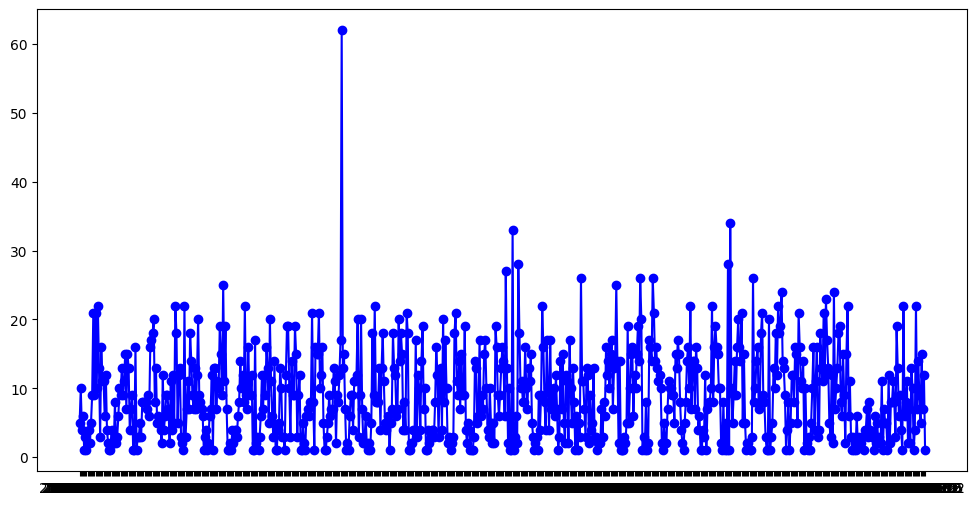

In [58]:
#plotting the data
plt.figure(figsize=(12, 6))
plt.plot(tsdata['Date'], tsdata['nombre_pannes'], marker='o', linestyle='-', color='b')

In [59]:
# Convert 'Date' column to ordinal values (numeric format)
tsdata['Date'] = pd.to_datetime(tsdata['Date']).apply(lambda x: x.toordinal())

# Define X and y
X = tsdata['Date'].values.reshape(-1, 1)  # Ensure X is reshaped as a 2D array
y = tsdata['nombre_pannes'].values.reshape(-1, 1)

### splitting the data

### creating and training the model

Epoch 1/50
19/19 [==============================] - 5s 26ms/step - loss: 0.0157
Epoch 2/50
19/19 [==============================] - 0s 26ms/step - loss: 0.0107
Epoch 3/50
19/19 [==============================] - 0s 23ms/step - loss: 0.0106
Epoch 4/50
19/19 [==============================] - 1s 34ms/step - loss: 0.0104
Epoch 5/50
19/19 [==============================] - 0s 25ms/step - loss: 0.0108
Epoch 6/50
19/19 [==============================] - 0s 25ms/step - loss: 0.0105
Epoch 7/50
19/19 [==============================] - 0s 24ms/step - loss: 0.0107
Epoch 8/50
19/19 [==============================] - 0s 25ms/step - loss: 0.0105
Epoch 9/50
19/19 [==============================] - 0s 25ms/step - loss: 0.0107
Epoch 10/50
19/19 [==============================] - 0s 24ms/step - loss: 0.0108
Epoch 11/50
19/19 [==============================] - 0s 24ms/step - loss: 0.0108
Epoch 12/50
19/19 [==============================] - 0s 22ms/step - loss: 0.0103
Epoch 13/50
19/19 [==================

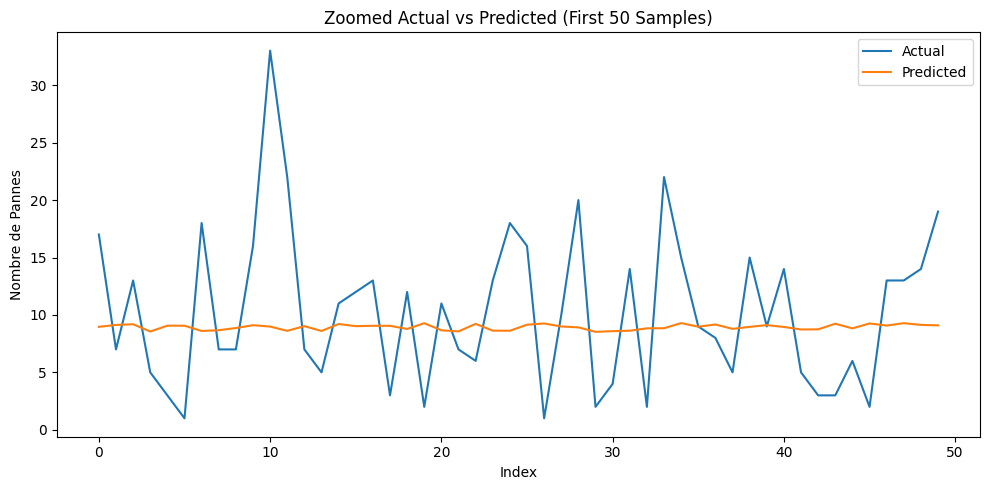

In [68]:


# Load and preprocess the data
tsdata = pd.read_csv('./CleanDataForTimeSeries.csv')
tsdata = tsdata[['Date', 'nombre_pannes']]
tsdata['Date'] = pd.to_datetime(tsdata['Date'])
tsdata.sort_values('Date', inplace=True)
tsdata['Date'] = tsdata['Date'].apply(lambda x: x.toordinal())

# Define X and y
X = tsdata['Date'].values.reshape(-1, 1)
y = tsdata['nombre_pannes'].values.reshape(-1, 1)

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Sequence generator
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

window_size = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

# Build the model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model_history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# Evaluate
mse = mean_squared_error(y_test_inv, y_pred)
print("MSE on test set:", mse)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:50], label='Actual')
plt.plot(y_pred[:50], label='Predicted')
plt.title('Zoomed Actual vs Predicted (First 50 Samples)')
plt.xlabel("Index")
plt.ylabel("Nombre de Pannes")
plt.legend()
plt.tight_layout()
plt.show()
